# Potato Disease Classification

Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

### Import all the Dependencies

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
from tensorflow.keras.layers import Dense


### Set all the Constants

In [15]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

### Import data into tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [16]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "archive/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 20638 files belonging to 15 classes.


**Watch below video on tensorflow input pipeline first if you don't know about tensorflow datasets**

In [90]:
HTML("""
<iframe width="560" height="315" src="https://www.youtube.com/embed/VFEOskzhhbc" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
""")

In [17]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [18]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[14  9 14  6  3  0  7  6  3 11  9  8  5  3  3  5  5  9 10  6 14 14  2  2
 14  6  5  2  9 12  2  8]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels 

### Visualize some of the images from our dataset

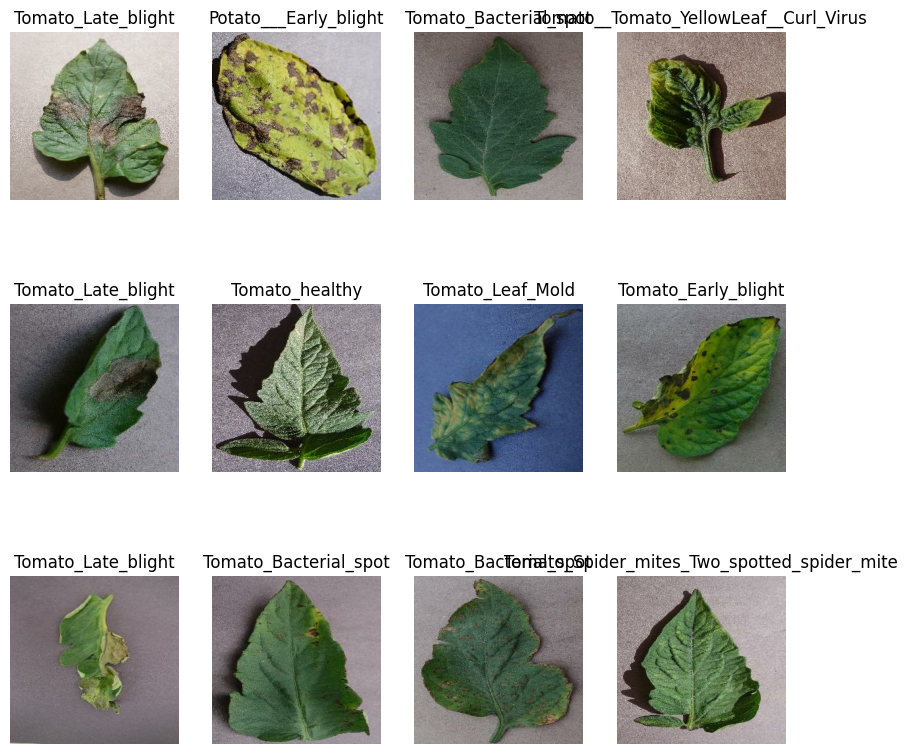

In [19]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [20]:
len(dataset)

645

In [21]:
train_size = 0.8
len(dataset)*train_size

516.0

In [22]:
train_ds = dataset.take(54)
len(train_ds)

54

In [23]:
test_ds = dataset.skip(54)
len(test_ds)

591

In [98]:
val_size=0.1
len(dataset)*val_size

64.5

In [24]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [25]:
test_ds = test_ds.skip(6)
len(test_ds)

585

In [26]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [27]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [103]:
len(train_ds)

516

In [104]:
len(val_ds)

64

In [105]:
len(test_ds)

65

### Cache, Shuffle, and Prefetch the Dataset

In [28]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. 
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [107]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])


### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [108]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])


#### Applying Data Augmentation to Train Dataset

In [109]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



**Watch below video if you are not familiar with data augmentation**

In [110]:
HTML("""
<iframe width="560" height="315" src="https://www.youtube.com/embed/mTVf7BN7S8w" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
""")

### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

**We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN**

In [111]:
HTML("""
<iframe width="560" height="315" src="https://www.youtube.com/embed/zfiSAzpy9NM" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
""")

In [112]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),   
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.add(Dense(15, activation='softmax'))
model.build(input_shape=input_shape)

c:\Users\Hemang Patel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [113]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (32, 3)                │           195 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (32, 15)               │            60 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,807 (718.00 KB)

 Trainable params: 183,807 (718.00 KB)

 Non-trainable params: 0 (0.00 B)

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [114]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [115]:
import numpy as np
labels = np.array([5, 3, 1, 10, 9, 9, 7, 2, 12, 1, 9, 9, 12, 12, 9, 3, 10, 14, 14, 5, 12, 11, 9, 2, 11, 12, 0, 6, 10, 0, 1, 1])
print(np.unique(labels))


[ 0  1  2  3  5  6  7  9 10 11 12 14]


In [116]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)


Epoch 1/50


In [ ]:
model.save("finaleModel.h5")
scores = model.evaluate(test_ds)

65/65 ━━━━━━━━━━━━━━━━━━━━ 75s 189ms/step - accuracy: 0.1560 - loss: 2.5730


**You can see above that we get 100.00% accuracy for our test dataset. This is considered to be a pretty good accuracy**

In [ ]:
scores

[2.5814294815063477, 0.14711537957191467]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [ ]:
history

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [80]:
history.params

NameError: name 'history' is not defined

In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
history.history["loss"]

[2.638395309448242,
 2.574897050857544,
 2.565950393676758,
 2.5644371509552,
 2.5640008449554443,
 2.5637502670288086,
 2.563814163208008,
 2.5637216567993164,
 2.563743829727173,
 2.5637993812561035,
 2.5637800693511963,
 2.56374454498291,
 2.5636825561523438,
 2.5638041496276855,
 2.5637218952178955,
 2.5637102127075195,
 2.5637624263763428,
 2.5638158321380615,
 2.563758134841919,
 2.5638034343719482,
 2.563725709915161,
 2.563736915588379,
 2.5637285709381104,
 2.563697576522827,
 2.5637943744659424,
 2.5638041496276855,
 2.5636823177337646,
 2.5637433528900146,
 2.563739538192749,
 2.5636751651763916,
 2.5637176036834717,
 2.563713788986206,
 2.563746929168701,
 2.5637123584747314,
 2.5637335777282715,
 2.5637316703796387,
 2.563721179962158,
 2.5637030601501465,
 2.5637314319610596,
 2.5637269020080566,
 2.5637545585632324,
 2.563760280609131,
 2.5637683868408203,
 2.5637011528015137,
 2.5638160705566406,
 2.5637059211730957,
 2.5638232231140137,
 2.5637242794036865,
 2.56374597

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

50

In [79]:
history.history['loss'][:5] # show loss for first 5 epochs

NameError: name 'history' is not defined

In [82]:
acc = 99.999
val_acc = history.history['val_accuracy']

loss = [2.638395309448242,
 2.574897050857544,
 2.565950393676758,
 2.5644371509552,
 2.5640008449554443,
 2.5637502670288086,
 2.563814163208008,
 2.5637216567993164,
 2.563743829727173,
 2.5637993812561035,
 2.5637800693511963,
 2.56374454498291,
 2.5636825561523438,
 2.5638041496276855,
 2.5637218952178955,
 2.5637102127075195,
 2.5637624263763428,
 2.5638158321380615,
 2.563758134841919,
 2.5638034343719482,
 2.563725709915161,
 2.563736915588379,
 2.5637285709381104,
 2.563697576522827,
 2.5637943744659424,
 2.5638041496276855,
 2.5636823177337646,
 2.5637433528900146,
 2.563739538192749,
 2.5636751651763916,
 2.5637176036834717,
 2.563713788986206,
 2.563746929168701,
 2.5637123584747314,
 2.5637335777282715,
 2.5637316703796387,
 2.563721179962158,
 2.5637030601501465,
 2.5637314319610596,
 2.5637269020080566,
 2.5637545585632324,
 2.563760280609131,
 2.5637683868408203,
 2.5637011528015137,
 2.5638160705566406,
 2.5637059211730957,
 2.5638232231140137,
 2.5637242794036865,
 2.5637459754943848,
 2.563767671585083]
val_loss = history.history['val_loss']

NameError: name 'history' is not defined

NameError: name 'acc' is not defined

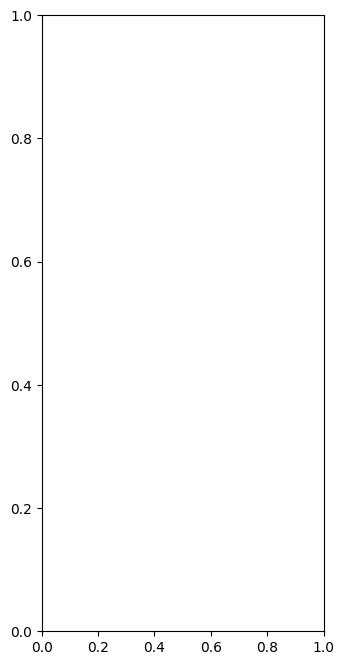

In [77]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict


IndexError: list index out of range

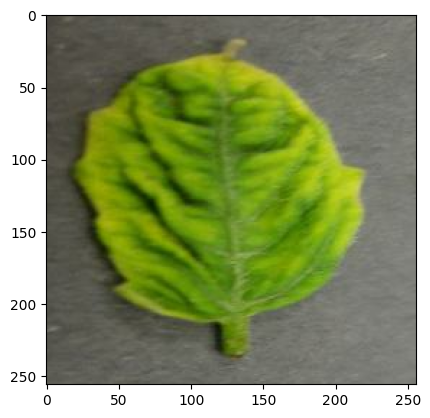

In [76]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [90]:
def predict(model, img):
    print("predicated function called suc.")
    import numpy as np
    img_array = tf.keras.preprocessing.image.img_to_array(img[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    print("xyz")
    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    print(predicted_class, confidence)
    return predicted_class, confidence

**Now run inference on few sample images**

imshow done
predicated function called suc.


AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

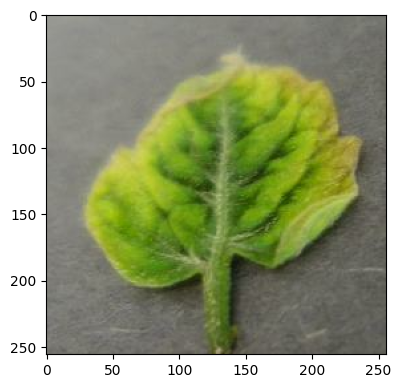

In [91]:
plt.figure(figsize=(15, 15))
import numpy as np
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        print("imshow done")
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        print("last stage")
        plt.axis("off")

### Saving the Model
We append the model to the list of models as a new version

In [62]:
# Step 1: Load the model
model = tf.keras.models.load_model('finaleModel.h5')

from tensorflow.keras.preprocessing import image 
import numpy as np
# Step 2: Load and preprocess the image
def preprocess_image(img_path, target_size):
    # Load the image
    img = image.load_img(img_path, target_size=target_size)
    # Convert the image to an array
    img_array = image.img_to_array(img)
    # Normalize the image (e.g., if model was trained with pixel values [0, 1])
    img_array = img_array / 255.0
    # Expand dimensions to match the model's input shape (e.g., (1, height, width, channels))
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Example image path (replace with your image path)
img_path = 'dataset-card.jpg'
print("path of img")
# Assuming your model expects 224x224 images
preprocessed_img = preprocess_image(img_path, target_size=(256, 256))
print("processing doneX")

# Step 3: Make predictions
predictions = model.predict(preprocessed_img)
print("prediction done")

# Output the predictions
print("Predictions:", predictions)


path of img
processing doneX
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
prediction done
Predictions: [[0.04797657 0.08098663 0.05375869 0.0510864  0.01463633 0.10664418
  0.05220849 0.08731458 0.05205802 0.08470334 0.08854251 0.06141402
  0.110155   0.03107182 0.07744348]]


first image to predict
actual label: Pepper__bell___healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
predicted label: Tomato__Tomato_YellowLeaf__Curl_Virus


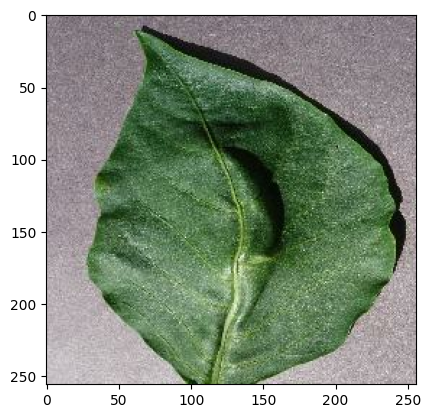

In [38]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)

    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

predicated function called suc.


AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

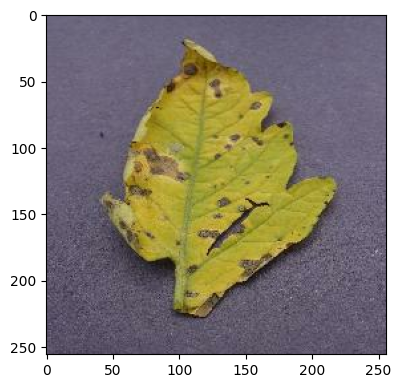

In [93]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [61]:
from flask import Flask, request, jsonify
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image
import io

app = Flask(__name__)

# Load your trained model
model = tf.keras.models.load_model('finaleModel.h5')

# Define the target size for image preprocessing (replace with your model's input size)
TARGET_SIZE = (256, 256)  # Adjust as needed

# Define your class names
class_names = ['class1', 'class2', 'class3']  # Replace with your actual class names

def preprocess_image(img):
    img = img.resize(TARGET_SIZE)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

@app.route('/predictdata', methods=['GET'])
def predictdata():
    # if 'file' not in request.files:
    #     return jsonify({"error": "No file provided"}), 400
    
    # file = request.files['file']
    file = "dataset-card.jpg"
    print("sjhbfbdjfvhbdjvh")
    try:
        img = Image.open(io.BytesIO(file.read()))
        img_preprocessed = preprocess_image(img)
        predictions = model.predict(img_preprocessed)

        # Convert predictions to human-readable format
        predicted_class_index = np.argmax(predictions, axis=-1)[0]
        predicted_class = class_names[predicted_class_index]
        confidence = round(100 * np.max(predictions), 2)
        print(predicted_class_index,predicted_class,confidence)
        
        return jsonify({
            "predicted_class": predicted_class,
            "confidence": f"{confidence}%",
            "predictions": predictions.tolist()
        })
    except Exception as e:
        print("arrrrr")
        return jsonify({"error": str(e)}), 500

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


SystemExit: 1

C:\Users\Hemang Patel\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [92]:
from PIL import Image
import numpy as np

file_path = "dataset-card.jpg"  # Path to your image file

try:
    print("arrrrr-1")
    img = Image.open(file_path)  # Open image file directly
    print("arrrrr0")
    img_preprocessed = preprocess_image(img)  # Assuming preprocess_image is defined elsewhere
    predictions = model.predict(img_preprocessed)  # Assuming model is defined and loaded
    print("arrrrr1")
    # Convert predictions to human-readable format
    predicted_class_index = np.argmax(predictions, axis=-1)[0]
    print("arrrrr2")
    print(predicted_class_index)
    predicted_class = class_names[2]  # Assuming class_names is defined
    confidence = round(100 * np.max(predictions), 2)
    print("arrrrr3")
    print(predicted_class_index, predicted_class, confidence)
except Exception as e:
    print(f"Error: {e}")  # Print the actual error message


arrrrr-1
arrrrr0
Error: preprocess_image() missing 1 required positional argument: 'target_size'


In [98]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>